In [25]:
import torch
import torchani
import pandas as pd
import numpy as np
from tqdm import tqdm

In [10]:
device = torch.device('cpu')
model = torchani.models.ANI1x()
ds = torchani.datasets.COMP6v1()

Name: ANI-BenchMD-wB97X-631Gd
ANI hdf5 store:
{'Conformer groups': 14,
 'Conformers': '1,791',
 'Properties': ['atomic_charges_cm5',
                'atomic_charges_hirshfeld',
                'atomic_dipoles_hirshfeld',
                'coordinates',
                'energies',
                'forces',
                'species']}
Name: S66x8-v1-wB97X-631Gd
ANI hdf5 store:
{'Conformer groups': 25,
 'Conformers': '528',
 'Properties': ['atomic_charges_cm5',
                'atomic_charges_hirshfeld',
                'atomic_dipoles_hirshfeld',
                'coordinates',
                'energies',
                'forces',
                'species']}
Name: DrugBank-testset-wB97X-631Gd
ANI hdf5 store:
{'Conformer groups': 93,
 'Conformers': '13,379',
 'Properties': ['atomic_charges_cm5',
                'atomic_charges_hirshfeld',
                'atomic_dipoles_hirshfeld',
                'coordinates',
                'energies',
                'forces',
                'species'

In [41]:
loops = 0
results = []

with ds.keep_open("r") as read_ds:
    total_chunks = read_ds.num_chunks(max_size=2500)
    for group, j, conformer in tqdm(read_ds.chunked_items(max_size=2500), total=total_chunks, desc="Processing chunks"):
        species = conformer["species"].to(device)
        coordinates = conformer["coordinates"].to(device)
        dataset_energies = conformer['energies']
        dataset_forces = conformer['forces']
        dataset_energies_cpu = dataset_energies.detach().cpu()
        dataset_forces_cpu = dataset_forces.detach().cpu()
        ani_input = (species, coordinates)
        model.set_enabled('energy_shifter', True)
        e_qbc = model.energies_qbcs(ani_input)
        energies_mean = e_qbc.energies.detach()
        energies_qbc = e_qbc.qbcs.detach()
        n_structures = energies_mean.shape[0]
        for i in range(n_structures):
            struct_id = f"{group}-{j}-idx{i}"
            species_list = species[i].tolist()
            dft_energies = dataset_energies[i].item()
            energy_this_structure = energies_mean[i].tolist()
            energy_qbc_this_structure = energies_qbc[i].tolist()
            record = {
                "id": struct_id,
                "species": species_list,
                "dataset_energy": dft_energies,
                "energy_mean": energy_this_structure,
                "energy_qbc": energy_qbc_this_structure,
            }
            results.append(record)
df_original = pd.DataFrame(results)


rocessing chunks: 100%|███████████████████████████████████████████████████████████████████████████████████| 295/295 [00:27<00:00, 10.86it/s]

In [42]:
df = df_original
df['dataset_energy'] = df['dataset_energy'].apply(torchani.units.hartree2kcalpermol)
df['energy_mean'] = df['energy_mean'].apply(torchani.units.hartree2kcalpermol)
df['energy_qbc'] = df['energy_qbc'].apply(torchani.units.hartree2kcalpermol)

df['n_atoms'] = df['species'].apply(len)
df['size_weighted_error'] = abs(df['dataset_energy']-df['energy_mean'])/(df['n_atoms'].apply(np.sqrt))

df

,id,species,dataset_energy,energy_mean,energy_qbc,n_atoms,size_weighted_error
0,ANI-BenchMD-wB97X-631Gd/020-0-idx0,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323365.609936,-323364.471567,0.216791,20,0.254547
1,ANI-BenchMD-wB97X-631Gd/020-0-idx1,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323375.401484,-323375.578608,0.220918,20,0.039606
2,ANI-BenchMD-wB97X-631Gd/020-0-idx2,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323370.103359,-323369.335685,0.230071,20,0.171657
3,ANI-BenchMD-wB97X-631Gd/020-0-idx3,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323369.378915,-323370.101688,0.184407,20,0.161617
4,ANI-BenchMD-wB97X-631Gd/020-0-idx4,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323373.288524,-323373.587001,0.244296,20,0.066741
...,...,...,...,...,...,...,...
101347,GDB13-13-wB97X-631Gd/038-0-idx19,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351292.843214,-351290.404962,0.349511,38,0.395537
101348,GDB13-13-wB97X-631Gd/038-0-idx20,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351447.549823,-351445.137523,0.246596,38,0.391327
101349,GDB13-13-wB97X-631Gd/038-0-idx21,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351393.836450,-351393.662136,0.266652,38,0.028277
101350,GDB13-13-wB97X-631Gd/038-0-idx22,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351178.029168,-351176.155648,0.376509,38,0.303925


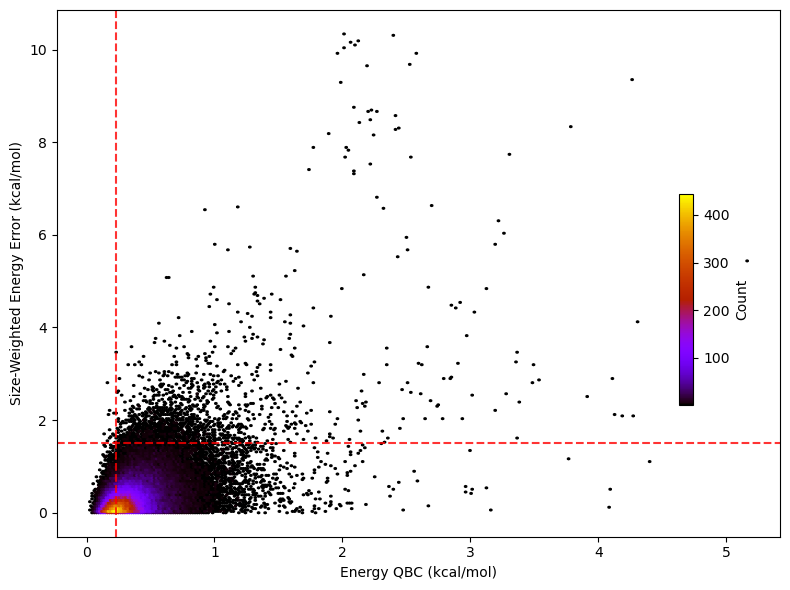

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
hb = plt.hexbin(df['energy_qbc'], df['size_weighted_error'], gridsize=300, cmap="gnuplot", mincnt=1)

# Reference lines
plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Horizontal line at 1.5 kcal/mol
plt.axvline(x=0.23, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Vertical line at 0.23 kcal/mol

plt.xlabel("Energy QBC (kcal/mol)")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.86, 0.25, 0.02, 0.4])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar
#plt.xlim(0, 7.5)  # Adjust based on main cluster range
#plt.ylim(0, 20.5)  # Adjust based on main cluster range

plt.tight_layout()
#plt.savefig('./figures/forces/qbc-vs-energy_error')

plt.show()


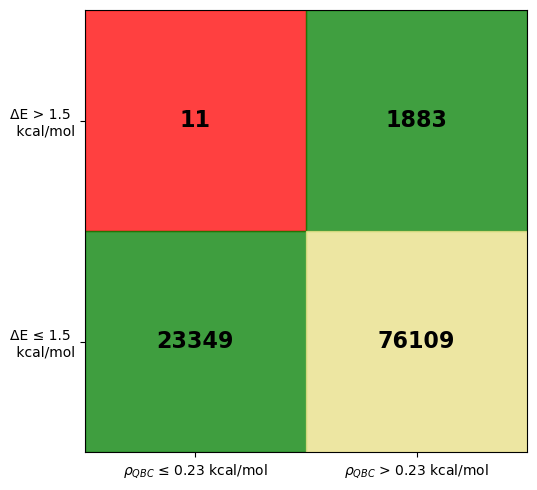

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define x and y thresholds
x_threshold = 0.23  # Example threshold for energy QBC
y_threshold = 1.5   # Example threshold for size-weighted energy error

# Load data for confusion matrix
df_conf_matrix = pd.DataFrame({
    "energy_qbc": df.groupby("id")["energy_qbc"].max(),
    "size_weighted_error": df.groupby("id")["size_weighted_error"].first()
}).reset_index()

# Classify points into quadrants
TP = ((df_conf_matrix["energy_qbc"] > x_threshold) & 
      (df_conf_matrix["size_weighted_error"] > y_threshold)).sum()

FN = ((df_conf_matrix["energy_qbc"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_error"] > y_threshold)).sum()

TN = ((df_conf_matrix["energy_qbc"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_error"] <= y_threshold)).sum()

FP = ((df_conf_matrix["energy_qbc"] > x_threshold) & 
      (df_conf_matrix["size_weighted_error"] <= y_threshold)).sum()

# Create confusion matrix
conf_matrix = np.array([[FN, TP], [TN, FP]])

# Define custom colors for each quadrant
color_map = np.array([["red", "green"],  # FN (light red), TP (green)
                      ["green", "khaki"]])   # TN (light green), FP (red)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ax.matshow(conf_matrix, cmap="Greys", alpha=0.1)  # Light background

# Manually color each cell
for i in range(2):
    for j in range(2):
        ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, color=color_map[i, j], alpha=0.75))

# Annotate each cell with the count
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", 
                color="black", fontsize=16, fontweight="bold")

# Set axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([fr"$\rho_{{QBC}}$ ≤ {x_threshold} kcal/mol", 
                    fr"$\rho_{{QBC}}$ > {x_threshold} kcal/mol"])
ax.set_yticklabels([f"ΔE > {y_threshold} \n kcal/mol", f"ΔE ≤ {y_threshold} \n kcal/mol"])

ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()


# Rotate x-axis labels for readability
#plt.xticks(rotation=20)

# Add title
#plt.title("Confusion Matrix: QBC vs. Energy Error", fontsize=12)
plt.tight_layout()
plt.savefig('./figures/forces/QBC_confusion.png')
plt.show()